# UrbanSound8k - Capstone Project - Part 2

## Cross Validation

**PROJECT OVERVIEW**
<br><br>
Environmental noise or noise pollution, which is defined as an unwanted or harmful outdoor sound created by human activity [1], is a growing problem in urban area. This noise pollution can affect the quality of life and health. Recent studies [2] have shown that exposure to noise pollution may increase the health risk. Therefore, decreasing the noise in the human environment can contribute to increase both the quality of life and health.
<br><br>
Environmental noise monitoring systems continuously measure the sound levels to quantify the noise level. However, it can be of interest to identify the type of noise source. By combining the noise level and the type of noise in real time we can describe the acoustic environment in a more complete way. Based on the outcome, actions can be taken to reduce the noise levels in urban areas. However, finding the type of noise can be a challenging task there an audio recording contains a mix of different noise sources. Here machine learning can be a helpful tool.
<br><br>
A way to build a real time monitoring system is the use of a low cost, small size, low power, wireless embedded device. Today, there is some attention to perform machine learning direct on these devices, so called machine learning on the edge, where we deploy a pre-trained neural network close to the sensor. However, because a limit memory footprint and compute resources the deployment of a neural network on an embedded device can be a challenge. Because these limitations trade-off needs to be made between memory footprint, compute power and the accuracy of the neural network.
<br><br>
**PROBLEM STATEMENT**
<br><br>
The design of a real time smart embedded monitoring system is, given the limit timeframe of this capstone project, out of the scope. The main objective of this capstone project is to take a first (small) step in the design of real time smart embedded system for environmental sound classification (ESC). In this capstone project we focus on the feature engineering step and the neural network design.
<br><br>
**DATASET**
<br><br>
For the project the [UrbandSound8k](https://urbansounddataset.weebly.com/urbansound8k.html) is selected.
The UrbanSound8k is a dataset that contains 8732 labelled sound excerpts of urban sounds, in WAV format. These excerpts are less or equal to 4s. There are 10 classes defined: air conditioner, car horn, children plying, dog bark, drilling, engine idling, gun shot, jackhammer, siren and street music. The sampling rate, bit depth, and number of channels can vary from file to file. The files are pre-sorted into ten folds for cross validation and saved in folders named fold1 to fold10. 
<br><br>
**REFERENCES**
<br><br>
[1] Directive 2002/49/EC of the European Parliament and of the Council of 25 June 2002 Relating to the Assessment and Management of Environmental Noise, Jun. 2002.
<br><br>
[2] L. Poon, The Sound of Heavy Traffic Might Take a Toll on Mental Health, CityLab. [Online]( https://www.citylab.com/equity/2015/11/city-noise-mental-health-traffic-study/417276/)
<br><br>
[3] J. Salamon, C. Jacoby and J. P. Bello, A dataset and Taxonomy for Urban Sound Research, 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014. [Paper (pdf)](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf)

In [1]:
import librosa
import librosa.display

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import keras
print(keras.__version__)

from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers

from keras.regularizers import l1
from keras.regularizers import l2

from keras.utils import to_categorical

from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import LeakyReLU

from keras.models import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import itertools

Using TensorFlow backend.


2.2.4


In [2]:
# ref.: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
# Read data
melspectrogram = []
labels = []

for i in range(1,11):
    melspectrogram.append(np.load("./dataset/audio/fold/melspectrogram_fold"+str(i)+".npy"))
    labels.append(np.load("./dataset/audio/fold/labels_fold"+str(i)+".npy"))

Test, fold:  1
Train, fold:  [2, 3, 4, 5, 6, 7, 8, 9, 10]


W1104 15:26:58.882889  7728 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1104 15:26:58.883888  7728 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1104 15:26:58.897889  7728 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1104 15:26:58.899889  7728 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1104 15:26:58.902889  7728 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

W1104 15:27:01.233012  7728 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
7859/7859 [==============================] - 17s 2ms/step - loss: 64.6819 - acc: 0.3000
Epoch 2/20
7859/7859 [==============================] - 11s 1ms/step - loss: 42.7163 - acc: 0.4903
Epoch 3/20
7859/7859 [==============================] - 11s 1ms/step - loss: 29.4238 - acc: 0.5978
Epoch 4/20
7859/7859 [==============================] - 11s 1ms/step - loss: 21.3019 - acc: 0.6996
Epoch 5/20
7859/7859 [==============================] - 11s 1ms/step - loss: 16.1270 - acc: 0.7646
Epoch 6/20
7859/7859 [==============================] - 11s 1ms/step - loss: 12.6413 - acc: 0.8077
Epoch 7/20
7859/7859 [==============================] - 11s 1ms/step - loss: 10.1204 - acc: 0.8409
Epoch 8/20
7859/7859 [==============================] - 11s 1ms/step - loss: 8.2590 - acc: 0.8563
Epoch 9/20
7859/7859 [==============================] - 11s 1ms/step - loss: 6.7748 - acc: 0.8791
Epoch 10/20
7859/7859 [==============================] - 11s 1ms/step - loss: 5.5875 - acc: 0.8967: 9s - lo - E

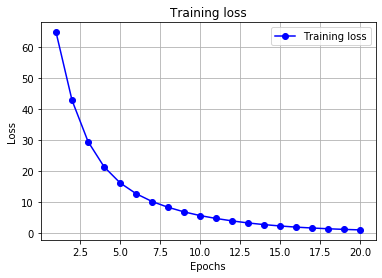

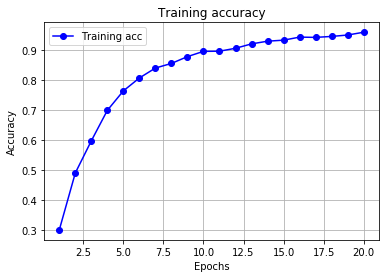


Test accurancy:
873/873 [==============================] - 1s 1ms/step
 68.95761743170836 %

Normalized confusion matrix
[[0.5  0.   0.02 0.04 0.01 0.35 0.   0.08 0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.   0.94 0.01 0.   0.   0.   0.   0.   0.03]
 [0.02 0.03 0.07 0.83 0.   0.02 0.   0.   0.   0.03]
 [0.12 0.09 0.04 0.01 0.42 0.13 0.02 0.16 0.01 0.  ]
 [0.28 0.   0.   0.   0.02 0.65 0.   0.   0.   0.05]
 [0.   0.   0.   0.03 0.   0.   0.94 0.03 0.   0.  ]
 [0.07 0.   0.   0.   0.33 0.28 0.   0.33 0.01 0.  ]
 [0.   0.   0.13 0.   0.   0.   0.   0.   0.87 0.  ]
 [0.02 0.   0.   0.   0.02 0.01 0.   0.04 0.03 0.88]]
Test accuracy = 68.95761741122566
Test, fold:  2
Train, fold:  [1, 3, 4, 5, 6, 7, 8, 9, 10]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________

<Figure size 432x288 with 0 Axes>

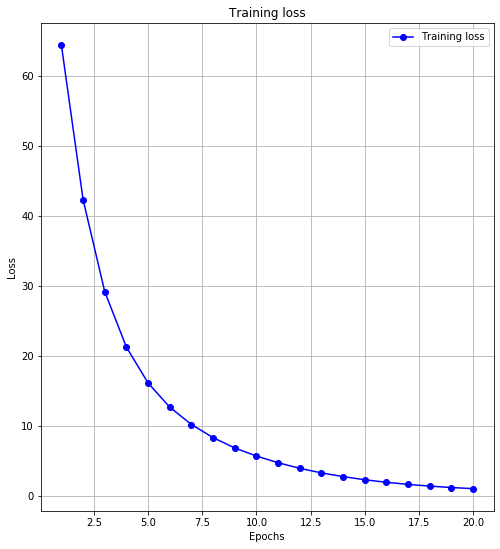

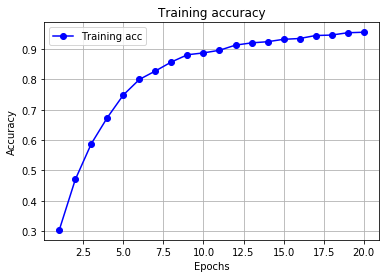


Test accurancy:
888/888 [==============================] - 1s 1ms/step
 65.54054056738948 %

Normalized confusion matrix
[[0.22 0.   0.   0.01 0.33 0.25 0.   0.16 0.   0.03]
 [0.   0.81 0.   0.02 0.   0.   0.   0.   0.   0.17]
 [0.04 0.   0.81 0.   0.   0.   0.   0.   0.   0.15]
 [0.   0.   0.02 0.97 0.   0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.04 0.82 0.   0.   0.13 0.   0.01]
 [0.27 0.   0.07 0.06 0.19 0.37 0.   0.03 0.   0.01]
 [0.   0.   0.   0.   0.03 0.   0.97 0.   0.   0.  ]
 [0.32 0.   0.   0.01 0.24 0.   0.   0.36 0.02 0.06]
 [0.02 0.   0.12 0.07 0.1  0.01 0.   0.   0.67 0.01]
 [0.02 0.01 0.04 0.   0.01 0.   0.   0.   0.01 0.91]]
Test accuracy = 65.54054054054053
Test, fold:  3
Train, fold:  [1, 2, 4, 5, 6, 7, 8, 9, 10]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________

<Figure size 432x288 with 0 Axes>

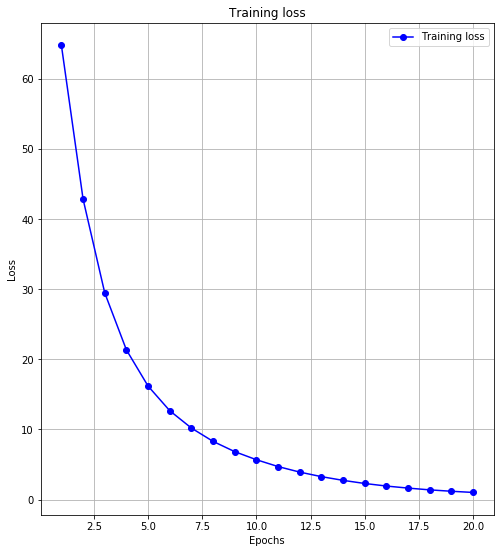

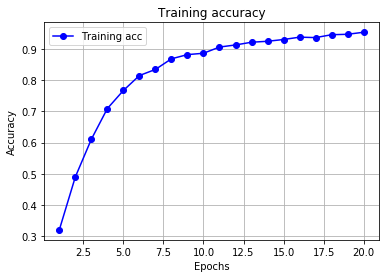


Test accurancy:
925/925 [==============================] - 1s 1ms/step
 69.29729732307229 %

Normalized confusion matrix
[[0.25 0.   0.   0.   0.19 0.43 0.   0.11 0.   0.02]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.03 0.   0.91 0.03 0.   0.03 0.   0.   0.   0.  ]
 [0.   0.03 0.09 0.86 0.   0.01 0.   0.   0.01 0.  ]
 [0.01 0.   0.   0.   0.61 0.2  0.   0.17 0.01 0.  ]
 [0.01 0.   0.02 0.01 0.   0.4  0.   0.56 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.94 0.06 0.   0.  ]
 [0.02 0.   0.   0.   0.23 0.06 0.   0.7  0.   0.  ]
 [0.03 0.   0.03 0.   0.   0.03 0.   0.   0.88 0.03]
 [0.04 0.05 0.11 0.01 0.01 0.06 0.   0.03 0.   0.69]]
Test accuracy = 69.2972972972973
Test, fold:  4
Train, fold:  [1, 2, 3, 5, 6, 7, 8, 9, 10]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
__________________________________________________________

<Figure size 432x288 with 0 Axes>

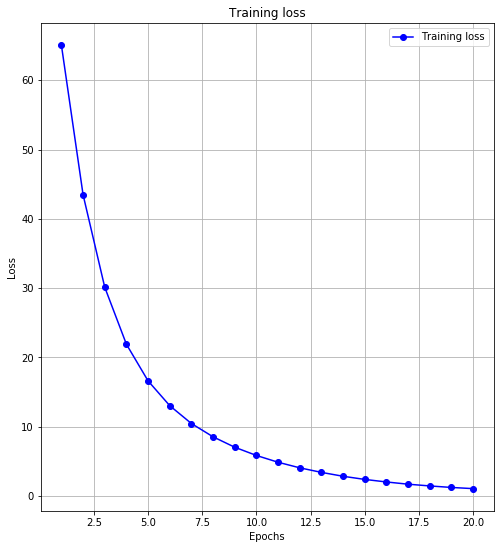

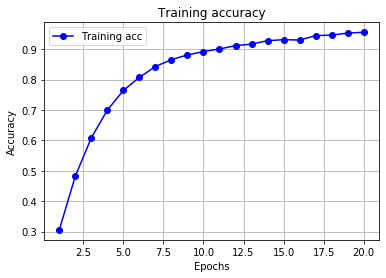


Test accurancy:
990/990 [==============================] - 1s 1ms/step
 69.99999997591732 %

Normalized confusion matrix
[[0.6  0.   0.   0.   0.12 0.02 0.   0.25 0.   0.01]
 [0.   0.59 0.   0.   0.19 0.   0.   0.   0.02 0.2 ]
 [0.02 0.   0.4  0.08 0.05 0.01 0.   0.   0.   0.44]
 [0.03 0.01 0.01 0.85 0.02 0.03 0.   0.01 0.02 0.02]
 [0.03 0.   0.   0.01 0.82 0.   0.   0.1  0.   0.04]
 [0.2  0.   0.   0.   0.16 0.6  0.   0.03 0.   0.02]
 [0.05 0.03 0.   0.11 0.05 0.   0.74 0.03 0.   0.  ]
 [0.03 0.02 0.   0.   0.27 0.04 0.01 0.53 0.   0.12]
 [0.03 0.   0.   0.03 0.   0.   0.   0.   0.87 0.07]
 [0.07 0.   0.   0.   0.01 0.   0.   0.   0.   0.92]]
Test accuracy = 70.0
Test, fold:  5
Train, fold:  [1, 2, 3, 4, 6, 7, 8, 9, 10]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv

<Figure size 432x288 with 0 Axes>

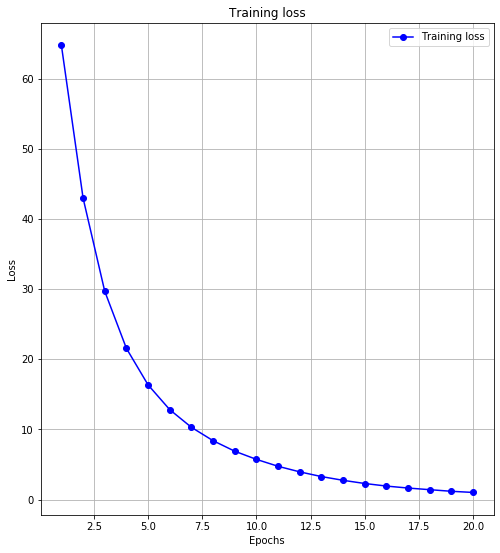

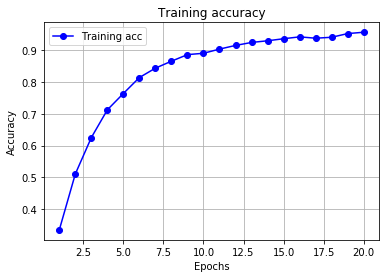


Test accurancy:
936/936 [==============================] - 1s 1ms/step
 81.73076923076923 %

Normalized confusion matrix
[[0.73 0.   0.   0.03 0.   0.24 0.   0.   0.   0.  ]
 [0.   0.7  0.   0.   0.   0.01 0.01 0.01 0.   0.27]
 [0.   0.   0.9  0.   0.05 0.03 0.01 0.   0.01 0.  ]
 [0.01 0.   0.13 0.77 0.01 0.03 0.05 0.   0.   0.  ]
 [0.06 0.   0.02 0.02 0.75 0.02 0.02 0.04 0.   0.07]
 [0.22 0.   0.01 0.01 0.02 0.62 0.01 0.1  0.   0.01]
 [0.03 0.   0.   0.   0.   0.   0.97 0.   0.   0.  ]
 [0.02 0.   0.   0.   0.03 0.01 0.   0.95 0.   0.  ]
 [0.01 0.04 0.03 0.01 0.   0.   0.   0.   0.9  0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   0.   0.   0.98]]
Test accuracy = 81.73076923076923
Test, fold:  6
Train, fold:  [1, 2, 3, 4, 5, 7, 8, 9, 10]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________

<Figure size 432x288 with 0 Axes>

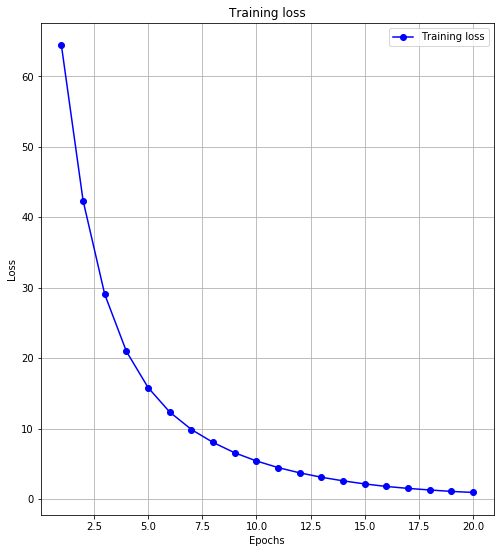

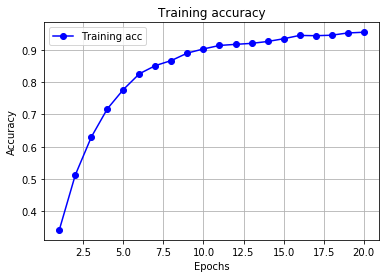


Test accurancy:
823/823 [==============================] - 1s 1ms/step
 75.33414332718924 %

Normalized confusion matrix
[[0.62 0.   0.   0.   0.   0.01 0.   0.02 0.   0.35]
 [0.   0.96 0.   0.   0.   0.   0.   0.04 0.   0.  ]
 [0.04 0.   0.92 0.   0.   0.01 0.01 0.01 0.   0.01]
 [0.01 0.   0.03 0.87 0.01 0.01 0.03 0.02 0.   0.02]
 [0.   0.   0.   0.01 0.89 0.   0.01 0.04 0.05 0.  ]
 [0.33 0.   0.03 0.   0.   0.47 0.   0.18 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.26 0.   0.   0.   0.   0.03 0.   0.71 0.   0.  ]
 [0.08 0.   0.05 0.01 0.16 0.03 0.   0.01 0.58 0.07]
 [0.03 0.02 0.14 0.   0.02 0.03 0.   0.   0.   0.76]]
Test accuracy = 75.33414337788578
Test, fold:  7
Train, fold:  [1, 2, 3, 4, 5, 6, 8, 9, 10]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________

<Figure size 432x288 with 0 Axes>

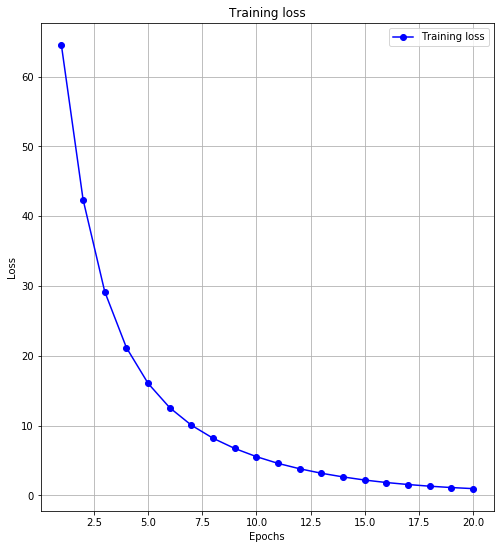

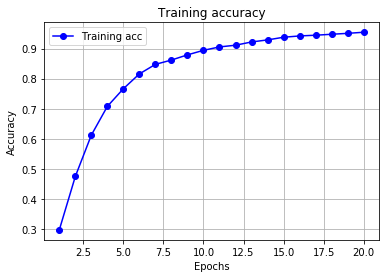


Test accurancy:
838/838 [==============================] - 1s 1ms/step
 77.32696897374701 %

Normalized confusion matrix
[[0.92 0.   0.   0.   0.   0.07 0.   0.01 0.   0.  ]
 [0.   0.93 0.   0.   0.   0.   0.   0.   0.   0.07]
 [0.1  0.   0.83 0.   0.   0.03 0.   0.   0.03 0.01]
 [0.01 0.   0.07 0.83 0.   0.   0.01 0.01 0.05 0.02]
 [0.1  0.   0.   0.   0.85 0.   0.   0.02 0.   0.03]
 [0.13 0.03 0.   0.   0.   0.62 0.   0.03 0.18 0.01]
 [0.04 0.   0.08 0.02 0.   0.   0.86 0.   0.   0.  ]
 [0.59 0.   0.   0.   0.28 0.   0.   0.13 0.   0.  ]
 [0.   0.04 0.   0.03 0.01 0.01 0.   0.   0.9  0.01]
 [0.04 0.   0.04 0.   0.   0.02 0.   0.   0.   0.9 ]]
Test accuracy = 77.32696897374701
Test, fold:  8
Train, fold:  [1, 2, 3, 4, 5, 6, 7, 9, 10]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________

<Figure size 432x288 with 0 Axes>

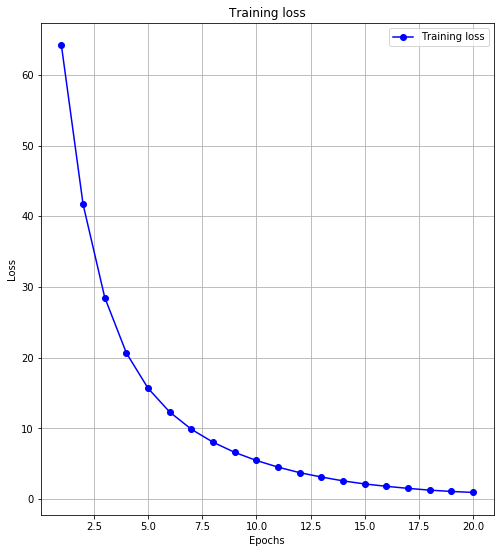

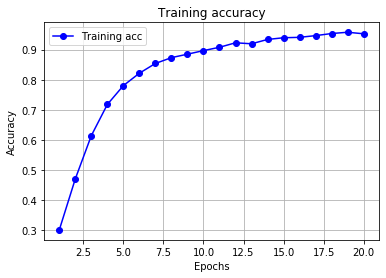


Test accurancy:
806/806 [==============================] - 1s 908us/step
 71.33995037960355 %

Normalized confusion matrix
[[0.31 0.   0.11 0.   0.35 0.   0.   0.   0.   0.23]
 [0.   0.9  0.   0.   0.   0.   0.   0.   0.   0.1 ]
 [0.04 0.   0.82 0.   0.01 0.05 0.   0.   0.01 0.07]
 [0.02 0.   0.06 0.84 0.02 0.   0.   0.   0.04 0.02]
 [0.   0.   0.   0.01 0.94 0.   0.   0.   0.02 0.03]
 [0.19 0.   0.03 0.01 0.   0.58 0.01 0.16 0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.01 0.   0.   0.   0.24 0.03 0.   0.72 0.   0.  ]
 [0.01 0.   0.   0.03 0.42 0.01 0.   0.   0.44 0.09]
 [0.   0.   0.02 0.06 0.02 0.   0.   0.02 0.03 0.85]]
Test accuracy = 71.33995037220843
Test, fold:  9
Train, fold:  [1, 2, 3, 4, 5, 6, 7, 8, 10]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_______________________________________________________

<Figure size 432x288 with 0 Axes>

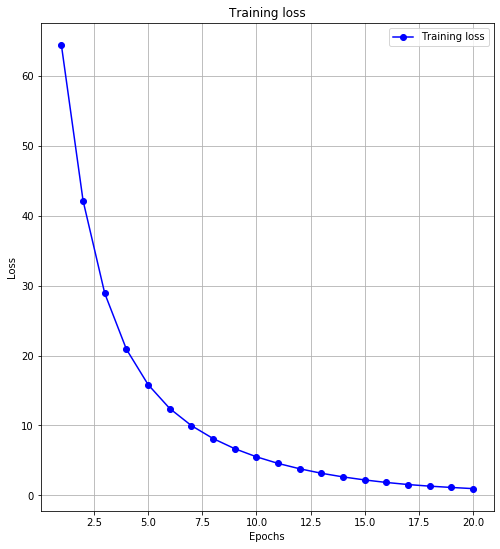

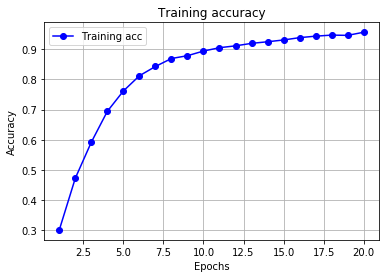


Test accurancy:
816/816 [==============================] - 1s 1ms/step
 82.59803921568627 %

Normalized confusion matrix
[[0.39 0.   0.   0.   0.28 0.05 0.   0.1  0.   0.18]
 [0.   0.97 0.   0.   0.   0.   0.   0.   0.   0.03]
 [0.01 0.   0.8  0.09 0.   0.03 0.   0.02 0.03 0.02]
 [0.06 0.01 0.01 0.86 0.02 0.03 0.   0.   0.   0.01]
 [0.   0.   0.   0.   0.7  0.06 0.   0.24 0.   0.  ]
 [0.   0.   0.   0.   0.   0.94 0.   0.03 0.02 0.  ]
 [0.   0.   0.   0.03 0.   0.   0.97 0.   0.   0.  ]
 [0.   0.   0.   0.   0.07 0.   0.   0.93 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.01]
 [0.02 0.   0.   0.   0.   0.   0.   0.   0.01 0.97]]
Test accuracy = 82.59803921568627
Test, fold:  10
Train, fold:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________

<Figure size 432x288 with 0 Axes>

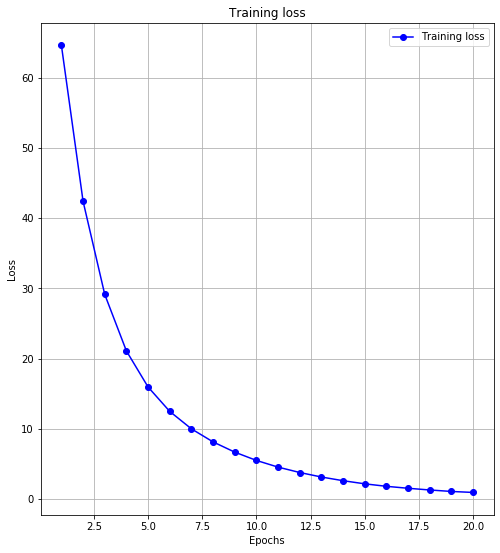

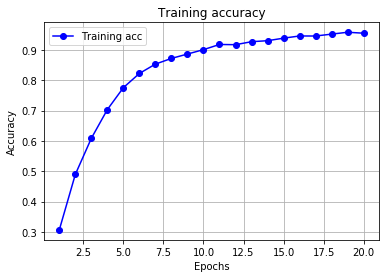


Test accurancy:
837/837 [==============================] - 1s 1ms/step
 82.19832737386012 %

Normalized confusion matrix
[[0.66 0.   0.17 0.   0.   0.   0.   0.06 0.11 0.  ]
 [0.   0.94 0.   0.   0.   0.   0.   0.   0.   0.06]
 [0.   0.   0.97 0.02 0.   0.   0.   0.01 0.   0.  ]
 [0.   0.01 0.13 0.75 0.02 0.   0.   0.02 0.   0.07]
 [0.   0.   0.05 0.   0.81 0.   0.   0.11 0.01 0.02]
 [0.08 0.   0.   0.01 0.   0.8  0.   0.09 0.   0.03]
 [0.   0.   0.   0.   0.03 0.   0.97 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.   0.99 0.   0.  ]
 [0.   0.   0.3  0.07 0.   0.01 0.01 0.01 0.59 0.  ]
 [0.   0.   0.11 0.   0.   0.   0.   0.   0.   0.89]]
Test accuracy = 82.19832735961768


<Figure size 432x288 with 0 Axes>

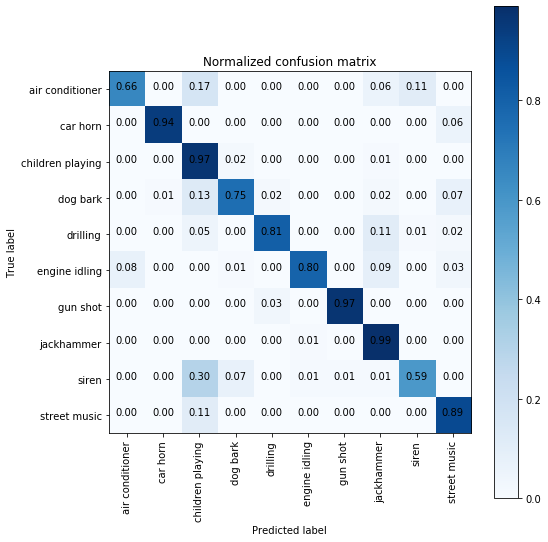

In [4]:
accurancy_fold = []

for fold_nmb in range(10):
    
    lr = 0.0001
    batch_size = 125
    epochs = 20

    fold = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    print('Test, fold: ', fold_nmb+1)
    fold.remove(fold_nmb+1)
    print('Train, fold: ', fold)
    
    melspectrogram_train = (melspectrogram[fold[0]-1], melspectrogram[fold[1]-1],
                            melspectrogram[fold[2]-1], melspectrogram[fold[3]-1], 
                            melspectrogram[fold[4]-1], melspectrogram[fold[5]-1], 
                            melspectrogram[fold[6]-1], melspectrogram[fold[7]-1],
                            melspectrogram[fold[8]-1])
    labels_train = (labels[fold[0]-1], labels[fold[1]-1], labels[fold[2]-1],
                    labels[fold[3]-1], labels[fold[4]-1], labels[fold[5]-1],
                    labels[fold[6]-1], labels[fold[7]-1], labels[fold[8]-1])

    melspectrogram_test = melspectrogram[fold_nmb]
    labels_test = labels[fold_nmb]
                        
    melspectrogram_train = np.concatenate(melspectrogram_train, axis=0)
    labels_train = np.concatenate(labels_train, axis=0)
    
    # ------------------------------------------------------------------------------------------------------
    
    mean = np.mean(melspectrogram_train, axis = 0)
    std = np.std(melspectrogram_train, axis = 0)

    X_train_stand_score = (melspectrogram_train-mean)/std
    X_test_stand_score = (melspectrogram[fold_nmb]-mean)/std
    
    # ------------------------------------------------------------------------------------------------------
    
    X_train = X_train_stand_score.reshape((X_train_stand_score.shape[0], X_train_stand_score.shape[1], X_train_stand_score.shape[2], 1))
    X_test = X_test_stand_score.reshape((X_test_stand_score.shape[0], X_test_stand_score.shape[1], X_test_stand_score.shape[2], 1))

    y_train = to_categorical(labels_train)
    y_test = to_categorical(labels_test)
    
    # ------------------------------------------------------------------------------------------------------
    # CNN24
    num_rows = X_train_stand_score.shape[1]
    num_columns = X_train_stand_score.shape[2]
    num_channels = 1
    num_labels = 10

    keras.backend.clear_session()
    
    model = models.Sequential()
    
    model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))       

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  

    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  

    model.add(Flatten())
          
    model.add(Dense(256,  kernel_regularizer=l2(0.1)))
    model.add(Activation('relu')) 
    model.add(Dropout(0.5))

    model.add(Dense(256, kernel_regularizer=l2(0.1)))
    model.add(Activation('relu')) 
    model.add(Dropout(0.5))

    model.add(Dense(10,activation ='softmax'))
    
    model.summary()
    
    opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size)
    
    history_dict = history.history
 
    acc = history.history['acc']
    loss = history.history['loss']

    epochs = range(1, len(acc) + 1)

    
    plt.clf()   # clear figure
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.clf()   # clear figure
    acc_values = history_dict['acc']

    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
    print('')
    print('Test accurancy:')
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('', 100*test_acc, '%')
    
    print('')
    y_pred = model.predict(X_test)

    classID = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    classes = ['air conditioner', 'car horn', 'children playing', 'dog bark', 
           'drilling','engine idling', 'gun shot', 'jackhammer', 'siren', 'street music']

    matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classID)
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    np.set_printoptions(precision=2)

    plt.clf()   # clear figure
    plt.figure(figsize=(8, 8))
    plot_confusion_matrix(matrix, classes=classes, normalize=True, title='Normalized confusion matrix')
    print("Test accuracy = " + str(100*accuracy))
    
    accurancy_fold.append(accuracy)

In [5]:
print(accurancy_fold)
print('Average test accurancy: ', 100*np.mean(accurancy_fold), '+/-', 100*np.std(accurancy_fold),'%')

[0.6895761741122566, 0.6554054054054054, 0.692972972972973, 0.7, 0.8173076923076923, 0.7533414337788579, 0.7732696897374701, 0.7133995037220844, 0.8259803921568627, 0.8219832735961768]
Average test accurancy:  74.4323653778978 +/- 5.950313091799977 %


---
### [EOF]